### Abstract. 

Classification of remote sensing multichannel images remains a challenging task due to the influence of several factors, including image compression and noise. In this study, we replicate and expand upon the previously conducted research on the classification of compressed noisy three-channel images by evaluating the potential of a new classifier based on the combination of Local Binary Patterns (LBP), color features, and the XGBoost algorithm. Specifically, we investigate the following factors: 1) the effect of residual noise after applying lossy compression to noisy images; 2) the impact of training a classifier on data that matches the quality conditions of the target compressed images; and 3) the benefits of post-filtering to improve the quality of compressed images before classification. Our experiments, conducted on Sentinel data with artificially added additive white Gaussian noise, demonstrate that the proposed LBP+Color+XGBoost classifier achieves competitive performance in handling noisy and compressed images. We confirm the importance of aligning classifier training with the quality conditions of the target images and highlight scenarios in which post-filtering can further enhance classification accuracy. These findings provide insights into the robustness of the LBP+Color+XGBoost pipeline for remote sensing data tasks involving challenging noise and compression conditions.

### Action Plan (in English)

1. **Develop a function to add Gaussian noise:**  
   Create a function that simulates the addition of Additive White Gaussian Noise (AWGN) to multichannel images.  

2. **Develop a function for image compression:**  
   Implement a function to compress images using lossy compression methods, such as JPEG or similar, with adjustable compression ratio parameters.

3. **Evaluate compressed images using PSNR:**  
   Develop a function to calculate the **Peak Signal-to-Noise Ratio (PSNR)** for compressed images. Use this function to identify the optimal compression ratio that yields the maximum PSNR value.

4. **Pixel-wise classification using the new classifier:**  
   Once the optimal compression point is determined, perform pixel-wise classification on the images using the proposed classifier **LBP+Color+XGBoost**. Analyze the classification results and assess the effectiveness of the new approach.

# 8 May discussion

Для перевірки зробити grayscale та порахувати PSNR, також 100
Також R G B - PSNR
Наступного разу спільна сесія, підготувати енв.



### Import libraries

In [38]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import paramiko
import os
from os.path import join  # Explicitly import `join` function

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
def add_awgn_noise(image, sigma_squared):
    """
    Додає Additive White Gaussian Noise (AWGN) до зображення.
    
    :param image: Вхідне зображення у форматі NumPy масиву (RGB).
    :param sigma_squared: Дисперсія шуму (sigma^2).
    :return: Зображення з доданим шумом.
    """
    # Переконайтеся, що вхідне зображення є дійсним NumPy масивом
    if not isinstance(image, np.ndarray):
        raise ValueError("Вхідне зображення повинно бути NumPy масивом.")
    
    # Переконайтеся, що дисперсія шуму (sigma^2) є невід’ємною
    if sigma_squared < 0:
        raise ValueError("Дисперсія шуму (sigma^2) повинна бути невід’ємним числом.")
    
    # Обчислення стандартного відхилення (sigma) як sqrt(sigma^2)
    sigma = np.sqrt(sigma_squared)
    
    # Генерування шуму з нормальним розподілом
    noise = np.random.normal(0, sigma, image.shape).astype(np.float32)
    
    # Додавання шуму до зображення
    noisy_image = image.astype(np.float32) + noise
    
    # Обмеження значень пікселів у діапазоні [0, 255]
    noisy_image = np.clip(noisy_image, 0, 255)
    
    # Перетворення зображення назад до його оригінального типу даних
    return noisy_image.astype(image.dtype)

In [24]:
# Function to upload files to the server
def upload_to_server(local_path, remote_path, server_ip, username, password):
    """
    Upload a file to the server via SFTP.
    """
    print(f"Uploading {local_path} to {remote_path} on server...")
    ssh = paramiko.SSHClient()
    ssh.set_missing_host_key_policy(paramiko.AutoAddPolicy())
    ssh.connect(server_ip, username=username, password=password)
    ftp_client = ssh.open_sftp()
    ftp_client.put(local_path, remote_path)
    ftp_client.close()
    ssh.close()

In [25]:
def download_from_server(remote_path, local_path, server_ip, username, password):
    """
    Download a file from the server to the local machine via SFTP.

    :param remote_path: Path to the file on the server.
    :param local_path: Path to save the file locally on the machine.
    :param server_ip: IP address of the server.
    :param username: Username for SSH access to the server.
    :param password: Password for SSH access to the server.
    """
    import paramiko
    print(f"Downloading {remote_path} from server to {local_path}...")
    ssh = paramiko.SSHClient()
    ssh.set_missing_host_key_policy(paramiko.AutoAddPolicy())
    ssh.connect(server_ip, username=username, password=password)
    ftp_client = ssh.open_sftp()
    ftp_client.get(remote_path, local_path)  # Use get() to download file from server
    ftp_client.close()
    ssh.close()

In [26]:
def calculate_psnr(original, noisy):
    """
    Calculates PSNR (Peak Signal-to-Noise Ratio) using OpenCV's built-in method.

    :param original: Original image as a NumPy array.
    :param noisy: Noisy image as a NumPy array.
    :return: PSNR value in decibels (float). Returns `inf` if the images are identical.
    """
    # Verify that the dimensions of the images match
    if original.shape != noisy.shape:
        raise ValueError("Original and noisy images must have the same shape.")

    # Use OpenCV's PSNR function
    psnr = cv2.PSNR(original, noisy)
    return psnr

In [48]:
def calculate_psnr_per_channel(original, decompressed_paths):
    """
    Calculate PSNR for each individual channel (R, G, B) independently.
    
    Parameters:
        original (np.array): Original RGB image array.
        decompressed_paths (dict): Dictionary with paths of decompressed R, G, B channel images.
    
    Returns:
        dict: Dictionary with PSNR values for R, G, B channels.
    """
    # Split the original image into channels
    r_orig, g_orig, b_orig = cv2.split(original)

    # Read decompressed images from decompressed paths
    try:
        r_dec = cv2.imread(decompressed_paths["R"], cv2.IMREAD_GRAYSCALE)
        g_dec = cv2.imread(decompressed_paths["G"], cv2.IMREAD_GRAYSCALE)
        b_dec = cv2.imread(decompressed_paths["B"], cv2.IMREAD_GRAYSCALE)

        # Check that decompressed channels are valid
        if r_dec is None or g_dec is None or b_dec is None:
            raise ValueError("One or more decompressed images could not be read. Check file paths.")

        # Ensure decompressed and original channels have the same shape
        if r_orig.shape != r_dec.shape or g_orig.shape != g_dec.shape or b_orig.shape != b_dec.shape:
            raise ValueError("Original and decompressed channel sizes do not match!")
        
    except Exception as e:
        raise RuntimeError(f"Error during channel loading or validation: {e}")

    # Debug: Check means of each channel (this can help to identify mismatches)
    print(f"Original channel means: R={np.mean(r_orig):.2f}, G={np.mean(g_orig):.2f}, B={np.mean(b_orig):.2f}")
    print(f"Decompressed channel means: R={np.mean(r_dec):.2f}, G={np.mean(g_dec):.2f}, B={np.mean(b_dec):.2f}")

    # Calculate PSNR for each channel
    psnr_values = {}
    psnr_values["R"] = cv2.PSNR(r_orig, r_dec)
    psnr_values["G"] = cv2.PSNR(g_orig, g_dec)
    psnr_values["B"] = cv2.PSNR(b_orig, b_dec)

    return psnr_values

In [49]:
def debug_visualize_channels(original, decompressed_paths, title_prefix=""):
    """
    Visualize original and decompressed channels for debugging alignment.
    """
    r_orig, g_orig, b_orig = cv2.split(original)
    r_dec = cv2.imread(decompressed_paths["R"], cv2.IMREAD_GRAYSCALE)
    g_dec = cv2.imread(decompressed_paths["G"], cv2.IMREAD_GRAYSCALE)
    b_dec = cv2.imread(decompressed_paths["B"], cv2.IMREAD_GRAYSCALE)

    plt.figure(figsize=(12, 8))

    # Original Channels
    plt.subplot(2, 3, 1)
    plt.imshow(r_orig, cmap="Reds")
    plt.title(f"{title_prefix}Original R")
    plt.axis("off")

    plt.subplot(2, 3, 2)
    plt.imshow(g_orig, cmap="Greens")
    plt.title(f"{title_prefix}Original G")
    plt.axis("off")

    plt.subplot(2, 3, 3)
    plt.imshow(b_orig, cmap="Blues")
    plt.title(f"{title_prefix}Original B")
    plt.axis("off")

    # Decompressed Channels
    plt.subplot(2, 3, 4)
    plt.imshow(r_dec, cmap="Reds")
    plt.title(f"{title_prefix}Decompressed R")
    plt.axis("off")

    plt.subplot(2, 3, 5)
    plt.imshow(g_dec, cmap="Greens")
    plt.title(f"{title_prefix}Decompressed G")
    plt.axis("off")

    plt.subplot(2, 3, 6)
    plt.imshow(b_dec, cmap="Blues")
    plt.title(f"{title_prefix}Decompressed B")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

Перевірка порядку кольорових каналів (R, G, B): Можна порівняти середнє значення кожного каналу оригінального та декодованого зображення. Це допоможе визначити, чи не переплутано канали.

In [50]:
def compare_channel_order(original, decompressed):
    original_mean = cv2.mean(original)
    decompressed_mean = cv2.mean(decompressed)
    print(f"Original channel means: {original_mean}")
    print(f"Decompressed channel means: {decompressed_mean}")

Перевірка кореляції каналів: Використання кореляції між каналами оригінального та декодованого зображення (за кожним каналом окремо) дозволить переконатись, що канали правильно порівнюються.

### Setting Up BGP Compression

There is no Python library that supports BGP directly, so we will use the command-line utilities `bpgenc` (for compression) and `bpgdec` (for decoding). We can integrate the calls to these utilities into Python using the `subprocess` library.

In progress ...

In [52]:
def run_bpg_on_server_per_channel(input_path, output_folder, quality, server_ip, username, password):
    """
    Perform independent BPG compression and decompression for each channel (R, G, B) on the server, 
    and download the decompressed components to the local machine.
    """
    import paramiko

    ssh = paramiko.SSHClient()
    ssh.set_missing_host_key_policy(paramiko.AutoAddPolicy())
    ssh.connect(server_ip, username=username, password=password)

    # Ensure the output folder exists on the server
    print(f"Ensuring output folder exists on server: {output_folder}")
    mkdir_cmd = f"mkdir -p {output_folder}"
    stdin, stdout, stderr = ssh.exec_command(mkdir_cmd)
    stderr_result = stderr.read().decode().strip()
    if stderr_result:
        raise RuntimeError(f"Failed to create output directory: {stderr_result}")

    # Split the channels
    print(f"Splitting channels of {input_path} on server...")
    r_path = join(output_folder, "R_channel.png")
    g_path = join(output_folder, "G_channel.png")
    b_path = join(output_folder, "B_channel.png")
    split_cmd = (
        f"convert {input_path} -channel R -separate {r_path}; "
        f"convert {input_path} -channel G -separate {g_path}; "
        f"convert {input_path} -channel B -separate {b_path}; "
    )
    stdin, stdout, stderr = ssh.exec_command(split_cmd)
    stderr_result = stderr.read().decode().strip()
    if stderr_result:
        raise RuntimeError(f"Error splitting channels: {stderr_result}")

    # Compress and decompress each channel
    decompressed_paths = {}
    local_folder = "./decompressed_channels/"  # Folder to store locally
    os.makedirs(local_folder, exist_ok=True)
    ftp_client = ssh.open_sftp()  # Use SFTP for file transfers

    for channel, channel_path in zip(["R", "G", "B"], [r_path, g_path, b_path]):
        compressed_bpg_path = join(output_folder, f"{channel}_compressed_q{quality}.bpg")
        decompressed_png_path = join(output_folder, f"{channel}_decompressed_q{quality}.png")
        local_png_path = join(local_folder, f"{channel}_decompressed_q{quality}.png")

        print(f"Compressing {channel} channel to {compressed_bpg_path}...")
        compress_cmd = f"bpgenc -o {compressed_bpg_path} -q {quality} {channel_path}"
        stdin, stdout, stderr = ssh.exec_command(compress_cmd)
        stderr_result = stderr.read().decode().strip()
        if stderr_result:
            raise RuntimeError(f"Error compressing {channel} channel: {stderr_result}")

        print(f"Decompressing {channel} channel to {decompressed_png_path}...")
        decompress_cmd = f"bpgdec -o {decompressed_png_path} {compressed_bpg_path}"
        stdin, stdout, stderr = ssh.exec_command(decompress_cmd)
        stderr_result = stderr.read().decode().strip()
        if stderr_result:
            raise RuntimeError(f"Error decompressing {channel} channel: {stderr_result}")

        # Download decompressed files from the server to local machine
        print(f"Downloading {decompressed_png_path} to {local_png_path} on local machine...")
        ftp_client.get(decompressed_png_path, local_png_path)

        # Store the local path for further processing
        decompressed_paths[channel] = local_png_path

    ftp_client.close()
    ssh.close()

    # Return paths to the locally downloaded decompressed channels
    return decompressed_paths

In [53]:
def display_multiple_images(images, titles, cmap=None):
    """
    Displays multiple images in a table layout in a Jupyter Notebook.

    :param images: List of images as NumPy arrays.
    :param titles: List of titles for the images.
    :param cmap: Color map; use 'gray' for monochrome images.
    """
    plt.figure(figsize=(15, 10))
    n = len(images)
    for i in range(n):
        plt.subplot(1, n, i + 1)
        if len(images[i].shape) == 2:  # Grayscale
            plt.imshow(images[i], cmap=cmap or 'gray')
        elif len(images[i].shape) == 3 and images[i].shape[2] == 3:  # RGB
            plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))  # Convert BGR to RGB
        else:
            raise ValueError("Unsupported image shape.")
        plt.title(titles[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [60]:
def reconstruct_rgb(decompressed_paths):
    """
    Reconstruct an RGB image from decompressed R, G, B channel images.
    
    :param decompressed_paths: Dictionary containing paths for decompressed R, G, B channel images.
    :return: Reconstructed RGB image.
    """
    r_dec = cv2.imread(decompressed_paths["R"], cv2.IMREAD_GRAYSCALE)
    g_dec = cv2.imread(decompressed_paths["G"], cv2.IMREAD_GRAYSCALE)
    b_dec = cv2.imread(decompressed_paths["B"], cv2.IMREAD_GRAYSCALE)

    return cv2.merge((r_dec, g_dec, b_dec))


In [55]:
def calculate_total_psnr(original, decompressed_rgb):
    """
    Calculate PSNR for the concatenated RGB image (decompressed) against the original RGB image.
    
    :param original: Original RGB image as a NumPy array.
    :param decompressed_rgb: Reconstructed RGB image from decompressed channels.
    :return: PSNR value for the total RGB image.
    """
    return cv2.PSNR(original, decompressed_rgb)

In [67]:
### Validate PSNR for compressed images

### Here we check decompresssed png with noise we get in script

local_shared_folder = "/Users/Maksym_Rybnytskyi/Library/CloudStorage/OneDrive-EPAM/Університет/Аспірантура/PhD/Repositories/xgboost-classifiers/Images/sentinel/SS2"  # Local path on MacBook
#noisy_shared_folder = "/Users/Maksym_Rybnytskyi/Library/CloudStorage/OneDrive-EPAM/Університет/Аспірантура/PhD/Repositories/xgboost-classifiers/Images/OOP+BPG"
noisy_shared_folder = "/Users/Maksym_Rybnytskyi/Library/CloudStorage/OneDrive-EPAM/Університет/Аспірантура/PhD/Repositories/xgboost-classifiers/Images/OOP+BPG"

image1_path_local = os.path.join(local_shared_folder, "SS2.bmp")
original_image = cv2.imread(image1_path_local, cv2.IMREAD_COLOR)
noisy_path_local = os.path.join(noisy_shared_folder, "decompressed_q1.png")
noisy_image = cv2.imread(noisy_path_local, cv2.IMREAD_COLOR)
psnr = calculate_psnr(original_image, noisy_image)

print(f'PSNR for decompressed noisy image: {psnr}')

### Here we check decompresssed png with noise we get manually

local_shared_folder = "/Users/Maksym_Rybnytskyi/Library/CloudStorage/OneDrive-EPAM/Університет/Аспірантура/PhD/Repositories/xgboost-classifiers/Images/sentinel/SS2"  # Local path on MacBook
noisy_shared_folder = "/Users/Maksym_Rybnytskyi/Library/CloudStorage/OneDrive-EPAM/Університет/Аспірантура/PhD/Repositories/xgboost-classifiers/Images/OOP+BPG"
image1_path_local = os.path.join(local_shared_folder, "SS2.bmp")
original_image = cv2.imread(image1_path_local, cv2.IMREAD_COLOR)
noisy_path_local = os.path.join(noisy_shared_folder, "decompressed_q10.png")
noisy_image = cv2.imread(noisy_path_local, cv2.IMREAD_COLOR)
psnr = calculate_psnr(original_image, noisy_image)

print(f'PSNR for decompressed noisy image: {psnr}')

### Here we check decompresssed png with noise we get manually

local_shared_folder = "/Users/Maksym_Rybnytskyi/Library/CloudStorage/OneDrive-EPAM/Університет/Аспірантура/PhD/Repositories/xgboost-classifiers/Images/sentinel/SS2"  # Local path on MacBook
noisy_shared_folder = "/Users/Maksym_Rybnytskyi/Library/CloudStorage/OneDrive-EPAM/Університет/Аспірантура/PhD/Repositories/xgboost-classifiers/Images/sentinel/SS2"  # Local path on MacBook
image1_path_local = os.path.join(local_shared_folder, "SS2.bmp")
original_image = cv2.imread(image1_path_local, cv2.IMREAD_COLOR)
noisy_path_local = os.path.join(noisy_shared_folder, "SS2_PSNR_31.7.bmp")
noisy_image = cv2.imread(noisy_path_local, cv2.IMREAD_COLOR)
psnr = calculate_psnr(original_image, noisy_image)

print(f'PSNR for decompressed noisy image: {psnr}')

### Here we check decompresssed png with noise we get manually

local_shared_folder = "/Users/Maksym_Rybnytskyi/Library/CloudStorage/OneDrive-EPAM/Університет/Аспірантура/PhD/Repositories/xgboost-classifiers/Images/sentinel/SS1"  # Local path on MacBook
noisy_shared_folder = "/Users/Maksym_Rybnytskyi/Documents/UTMShare"  # Local path on MacBook
image1_path_local = os.path.join(local_shared_folder, "SS1.bmp")
original_image = cv2.imread(image1_path_local, cv2.IMREAD_COLOR)
noisy_path_local = os.path.join(noisy_shared_folder, "reconstructed_q1_sigma_25_img_1.png")
noisy_image = cv2.imread(noisy_path_local, cv2.IMREAD_COLOR)
psnr = calculate_psnr(original_image, noisy_image)

print(f'PSNR for decompressed noisy image: {psnr}')

PSNR for decompressed noisy image: 35.7325812427053
PSNR for decompressed noisy image: 35.58185686761592
PSNR for decompressed noisy image: 31.723212705660572
PSNR for decompressed noisy image: 28.727091491687947


In [57]:
### Validate PSNR calculation. It should be 33.8

local_shared_folder = "/Users/Maksym_Rybnytskyi/Library/CloudStorage/OneDrive-EPAM/Університет/Аспірантура/PhD/Repositories/xgboost-classifiers/Images/sentinel/SS1"  # Local path on MacBook
image1_path_local = os.path.join(local_shared_folder, "SS1.bmp")
original_image = cv2.imread(image1_path_local, cv2.IMREAD_COLOR)
noisy_path_local = os.path.join(local_shared_folder, "SS1_PSNR_33.8.bmp")
noisy_image = cv2.imread(noisy_path_local, cv2.IMREAD_COLOR)
psnr = calculate_psnr(original_image, noisy_image)

print(psnr)

33.82459311193631


# What's Next?

1. Analyse results and define OOP for SS1 and SS2.
2. Prepare images in advance. I can add this code here to store all images with required names in specified folder.
3. Extend functionality of LBP+Color+XGBoost per-pixel Sentinel.ipynb notebook and add additional function that will train and classify in cycle using provided images. 

# Results

We have got the following PSNR values for Noisy images without compression. This is our start point for future analysis.

### SS1 

- Noise (σ=25): PSNR=34.43 dB
- Noise (σ=50): PSNR=31.58 dB 
- Noise (σ=100): PSNR=28.73 dB

### SS2

- Noise (σ=25): PSNR=34.16 dB
- Noise (σ=50): PSNR=31.21 dB
- Noise (σ=100): PSNR=28.25 dB

PSNR improvement is clearly visible for noisy image SS1(sigm2^2=100). **OOP is located at Q=33**, after this value PSNR metric start to decrease. Also it worth nothing that metric was not changing until on range Q<27. Significant grow started after Q(OOP-4).

For SS2 we have different picture. There is no visible OOP, but we can call OOP the point after which metrics start significant decrease. For SS2 this is the same as for SS1, Q=33

Also BGP compression improves PSNR metric starting from Q=1. Here is results of PSNR for Q1 for different noise level. 

### Decompressed SS1 (Q=1)

- Noise (σ=25): PSNR=35.41 dB
- Noise (σ=50): PSNR=33.37 dB
- Noise (σ=100): PSNR=31.00 dB

### Decompressed SS2 (Q=1)

- Noise (σ=25): PSNR=33.25 dB
- Noise (σ=50): PSNR=31.71 dB
- Noise (σ=100): PSNR=29.71 dB

As we can see PSNR metric is improved even for Q1, this improvement for SS1 led in range from 1-2,5 dB, for SS2 0.5-1.5 dB.

So the next investigation will be based on this results.

We will estimate classification accuracy for the following images with different noise.

- original noisy image
- noisy image with compression in OOP
- noisy image with compression in OOP-4

All images are gathered in folder ./Images/OOP+BPG

SS1.bmp  
SS2.bmp  
decompressed_q29_sigma_100_img_1.png  
decompressed_q29_sigma_100_img_2.png 
decompressed_q29_sigma_25_img_1.png  
decompressed_q29_sigma_25_img_2.png  
decompressed_q29_sigma_50_img_1.png  
decompressed_q29_sigma_50_img_2.png  
decompressed_q33_sigma_100_img_1.png  
decompressed_q33_sigma_100_img_2.png  
decompressed_q33_sigma_25_img_1.png  
decompressed_q33_sigma_25_img_2.png  
decompressed_q33_sigma_50_img_1.png  
decompressed_q33_sigma_50_img_2.png  
noisy_sigma_100_img_1.bmp  
noisy_sigma_100_img_2.bmp  
noisy_sigma_25_img_1.bmp  
noisy_sigma_25_img_2.bmp  
noisy_sigma_50_img_1.bmp  
noisy_sigma_50_img_2.bmp  

Uploading /Users/Maksym_Rybnytskyi/Documents/UTMShare/SS1.bmp to server at /home/max/Documents/SS1.bmp...
Uploading /Users/Maksym_Rybnytskyi/Documents/UTMShare/SS1.bmp to /home/max/Documents/SS1.bmp on server...
Uploading /Users/Maksym_Rybnytskyi/Documents/UTMShare/SS2.bmp to server at /home/max/Documents/SS2.bmp...
Uploading /Users/Maksym_Rybnytskyi/Documents/UTMShare/SS2.bmp to /home/max/Documents/SS2.bmp on server...
Processing Image 1
-------------------------------------------------------
Uploading /Users/Maksym_Rybnytskyi/Documents/UTMShare/noisy_sigma_25_img_1.bmp to /home/max/Documents/noisy_sigma_25_img_1.bmp on server...
Uploading /Users/Maksym_Rybnytskyi/Documents/UTMShare/noisy_sigma_50_img_1.bmp to /home/max/Documents/noisy_sigma_50_img_1.bmp on server...
Uploading /Users/Maksym_Rybnytskyi/Documents/UTMShare/noisy_sigma_100_img_1.bmp to /home/max/Documents/noisy_sigma_100_img_1.bmp on server...


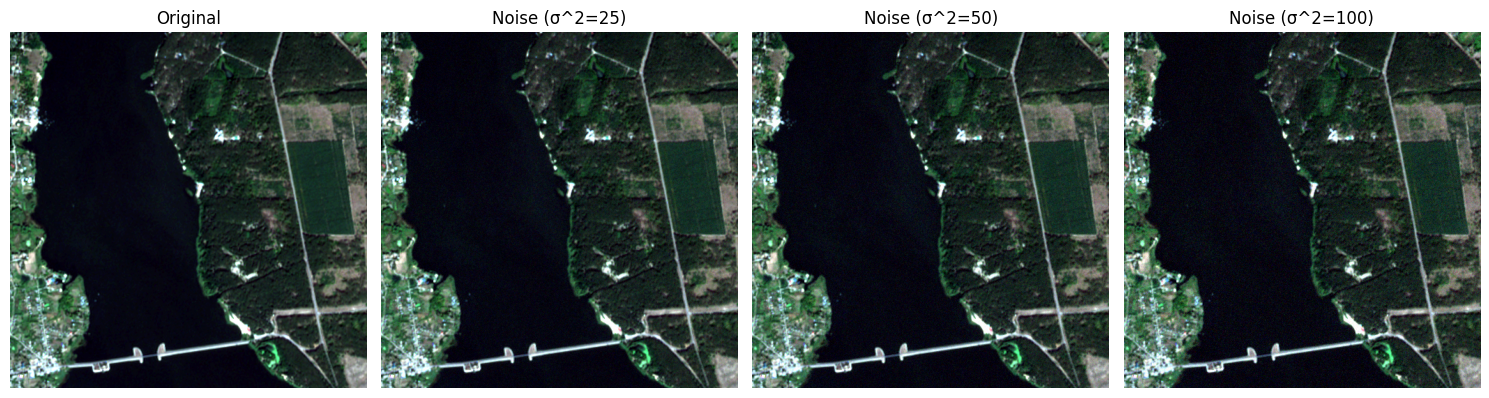


PSNR values for noisy images:
Noise (σ=25): PSNR=34.42 dB
Noise (σ=50): PSNR=31.57 dB
Noise (σ=100): PSNR=28.72 dB
-------------------------------------------------------

Analyzing compression for Image 1, Sigma=25
-------------------------------------------------------
Processing BPG compression with Q=1...
Ensuring output folder exists on server: /home/max/Documents/temp
Splitting channels of /home/max/Documents/noisy_sigma_25_img_1.bmp on server...
Compressing R channel to /home/max/Documents/temp/R_compressed_q1.bpg...
Decompressing R channel to /home/max/Documents/temp/R_decompressed_q1.png...
Compressing G channel to /home/max/Documents/temp/G_compressed_q1.bpg...
Decompressing G channel to /home/max/Documents/temp/G_decompressed_q1.png...
Compressing B channel to /home/max/Documents/temp/B_compressed_q1.bpg...
Decompressing B channel to /home/max/Documents/temp/B_decompressed_q1.png...
Original channel means: R=35.48, G=46.64, B=45.26
Decompressed channel means: R=35.19, G=46.

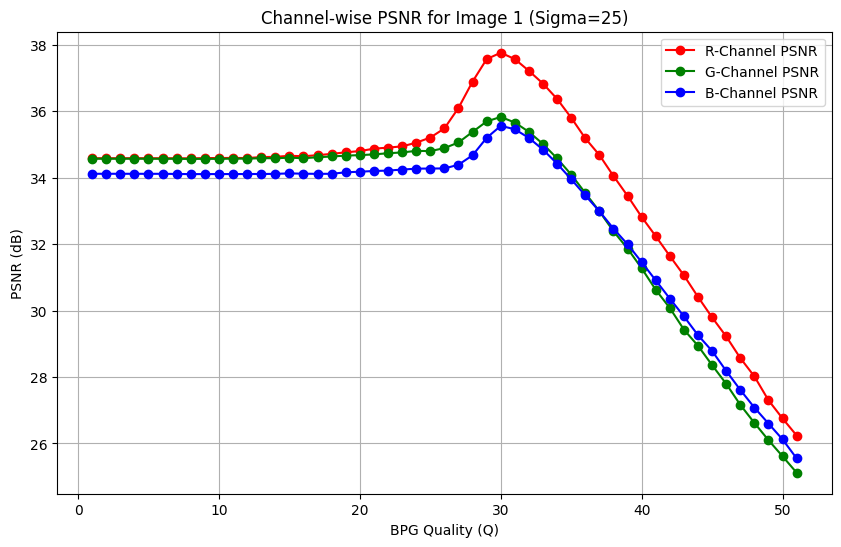

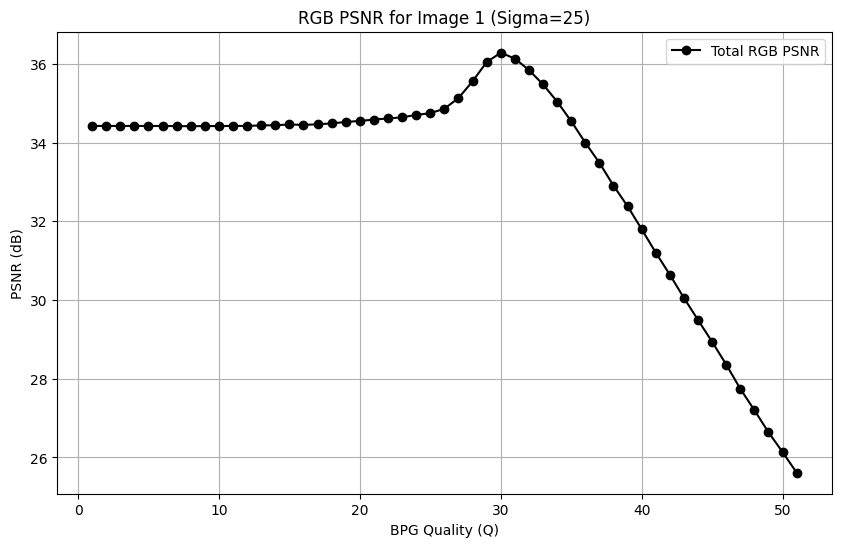


Analyzing compression for Image 1, Sigma=50
-------------------------------------------------------
Processing BPG compression with Q=1...
Ensuring output folder exists on server: /home/max/Documents/temp
Splitting channels of /home/max/Documents/noisy_sigma_50_img_1.bmp on server...
Compressing R channel to /home/max/Documents/temp/R_compressed_q1.bpg...
Decompressing R channel to /home/max/Documents/temp/R_decompressed_q1.png...
Compressing G channel to /home/max/Documents/temp/G_compressed_q1.bpg...
Decompressing G channel to /home/max/Documents/temp/G_decompressed_q1.png...
Compressing B channel to /home/max/Documents/temp/B_compressed_q1.bpg...
Decompressing B channel to /home/max/Documents/temp/B_decompressed_q1.png...
Original channel means: R=35.48, G=46.64, B=45.26
Decompressed channel means: R=35.40, G=46.61, B=44.79
PSNR per channel (Q=1): {'R': 31.81089574553118, 'G': 31.75269205090821, 'B': 31.18129266550174}
Total PSNR for RGB reconstruction (Q=1): 31.572202528063023
Pro

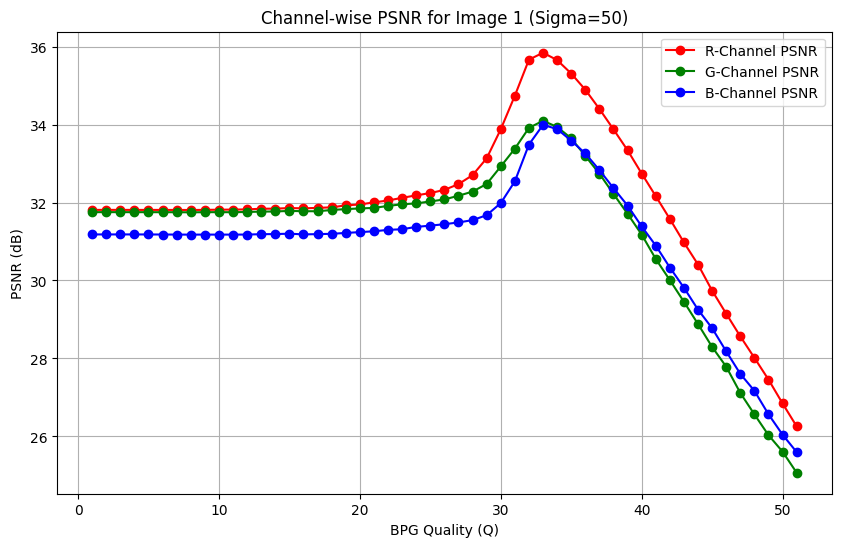

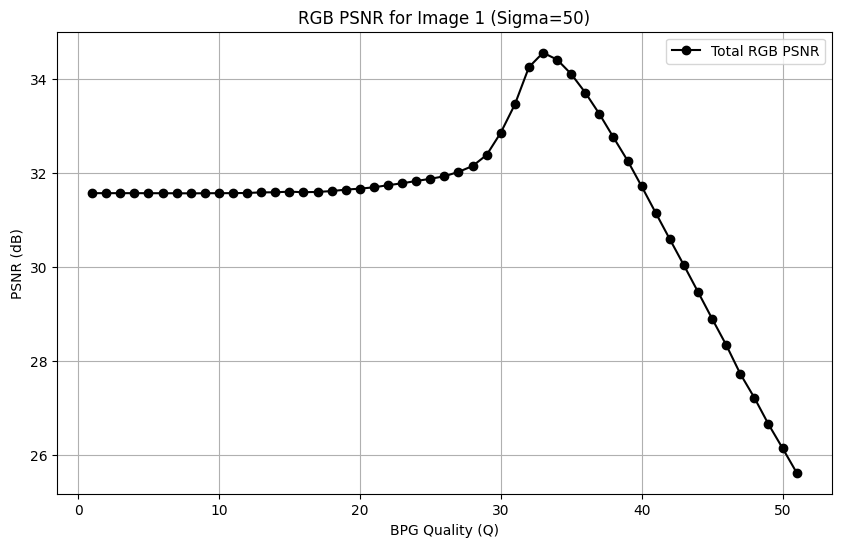


Analyzing compression for Image 1, Sigma=100
-------------------------------------------------------
Processing BPG compression with Q=1...
Ensuring output folder exists on server: /home/max/Documents/temp
Splitting channels of /home/max/Documents/noisy_sigma_100_img_1.bmp on server...
Compressing R channel to /home/max/Documents/temp/R_compressed_q1.bpg...
Decompressing R channel to /home/max/Documents/temp/R_decompressed_q1.png...
Compressing G channel to /home/max/Documents/temp/G_compressed_q1.bpg...
Decompressing G channel to /home/max/Documents/temp/G_decompressed_q1.png...
Compressing B channel to /home/max/Documents/temp/B_compressed_q1.bpg...
Decompressing B channel to /home/max/Documents/temp/B_decompressed_q1.png...
Original channel means: R=35.48, G=46.64, B=45.26
Decompressed channel means: R=35.83, G=46.97, B=44.83
PSNR per channel (Q=1): {'R': 28.976724777417683, 'G': 28.894757579670795, 'B': 28.315817688027252}
Total PSNR for RGB reconstruction (Q=1): 28.71899508564187

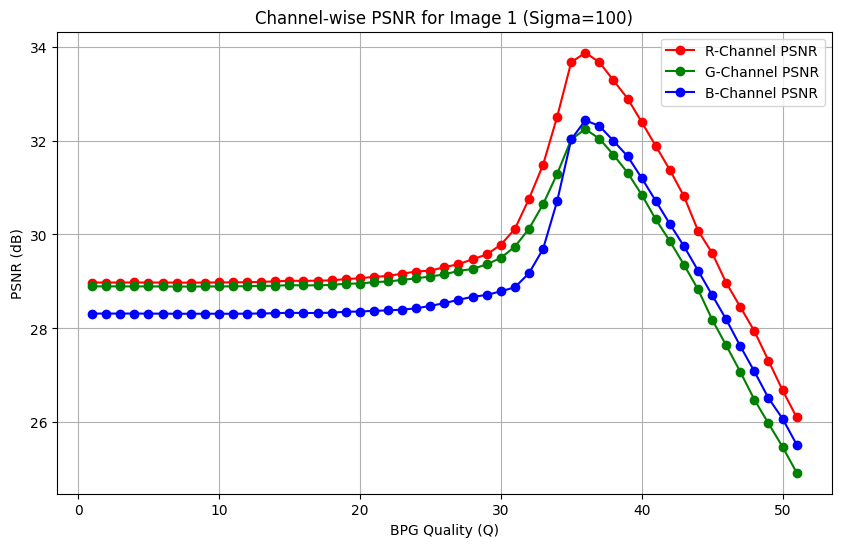

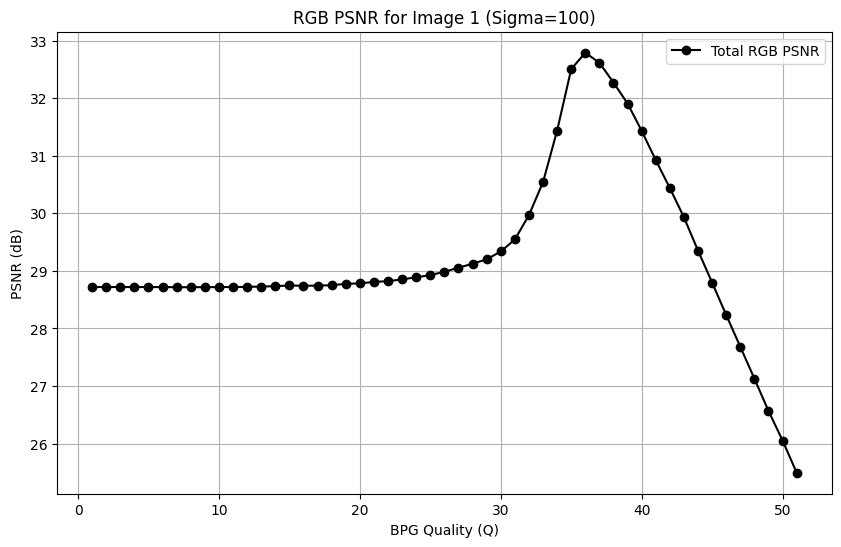

Finished processing Image 1
Processing Image 2
-------------------------------------------------------
Uploading /Users/Maksym_Rybnytskyi/Documents/UTMShare/noisy_sigma_25_img_2.bmp to /home/max/Documents/noisy_sigma_25_img_2.bmp on server...
Uploading /Users/Maksym_Rybnytskyi/Documents/UTMShare/noisy_sigma_50_img_2.bmp to /home/max/Documents/noisy_sigma_50_img_2.bmp on server...
Uploading /Users/Maksym_Rybnytskyi/Documents/UTMShare/noisy_sigma_100_img_2.bmp to /home/max/Documents/noisy_sigma_100_img_2.bmp on server...


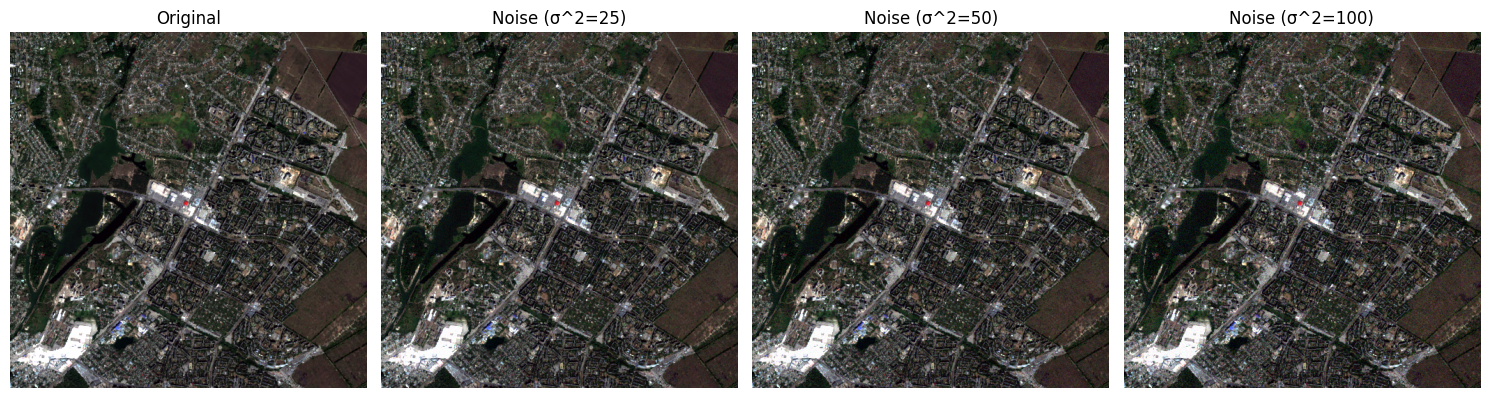


PSNR values for noisy images:
Noise (σ=25): PSNR=34.16 dB
Noise (σ=50): PSNR=31.20 dB
Noise (σ=100): PSNR=28.25 dB
-------------------------------------------------------

Analyzing compression for Image 2, Sigma=25
-------------------------------------------------------
Processing BPG compression with Q=1...
Ensuring output folder exists on server: /home/max/Documents/temp
Splitting channels of /home/max/Documents/noisy_sigma_25_img_2.bmp on server...
Compressing R channel to /home/max/Documents/temp/R_compressed_q1.bpg...
Decompressing R channel to /home/max/Documents/temp/R_decompressed_q1.png...
Compressing G channel to /home/max/Documents/temp/G_compressed_q1.bpg...
Decompressing G channel to /home/max/Documents/temp/G_decompressed_q1.png...
Compressing B channel to /home/max/Documents/temp/B_compressed_q1.bpg...
Decompressing B channel to /home/max/Documents/temp/B_decompressed_q1.png...
Original channel means: R=63.90, G=63.35, B=58.37
Decompressed channel means: R=63.41, G=62.

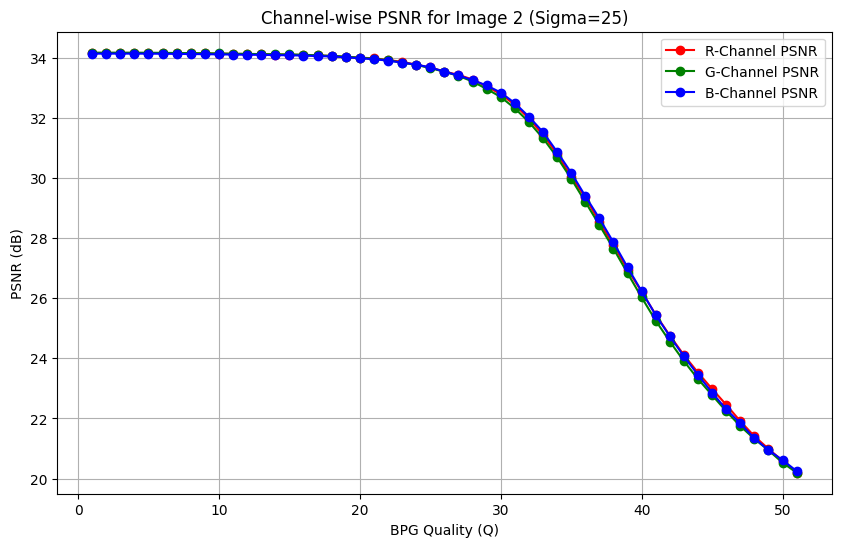

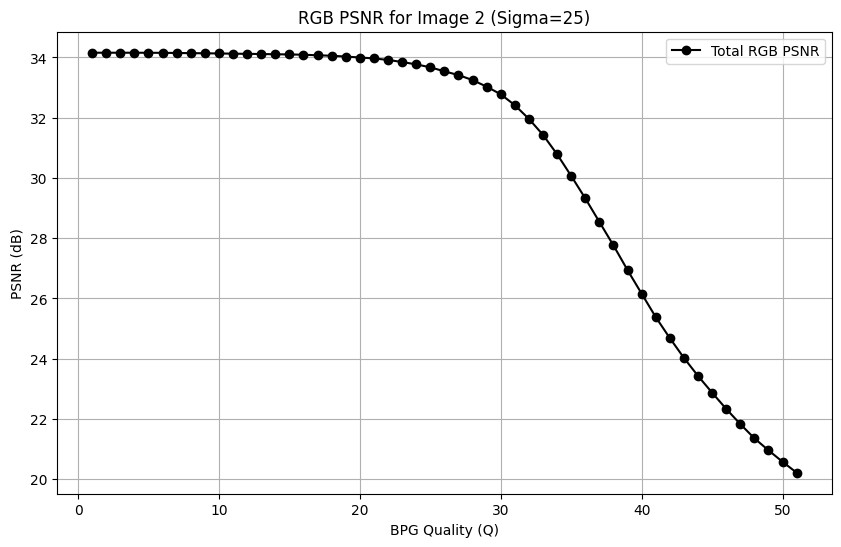


Analyzing compression for Image 2, Sigma=50
-------------------------------------------------------
Processing BPG compression with Q=1...
Ensuring output folder exists on server: /home/max/Documents/temp
Splitting channels of /home/max/Documents/noisy_sigma_50_img_2.bmp on server...
Compressing R channel to /home/max/Documents/temp/R_compressed_q1.bpg...
Decompressing R channel to /home/max/Documents/temp/R_decompressed_q1.png...
Compressing G channel to /home/max/Documents/temp/G_compressed_q1.bpg...
Decompressing G channel to /home/max/Documents/temp/G_decompressed_q1.png...
Compressing B channel to /home/max/Documents/temp/B_compressed_q1.bpg...
Decompressing B channel to /home/max/Documents/temp/B_decompressed_q1.png...
Original channel means: R=63.90, G=63.35, B=58.37
Decompressed channel means: R=63.40, G=62.91, B=57.88
PSNR per channel (Q=1): {'R': 31.213881878419624, 'G': 31.20577661189861, 'B': 31.189966834241496}
Total PSNR for RGB reconstruction (Q=1): 31.203197084352787
P

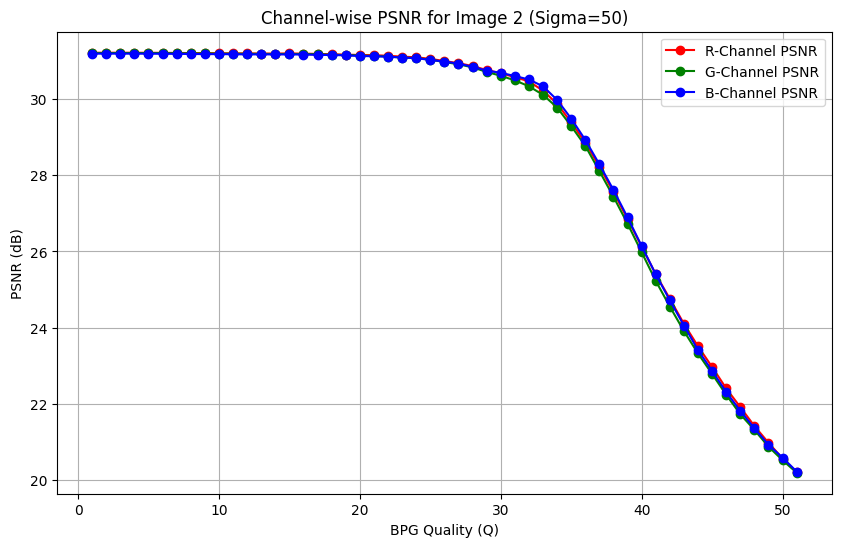

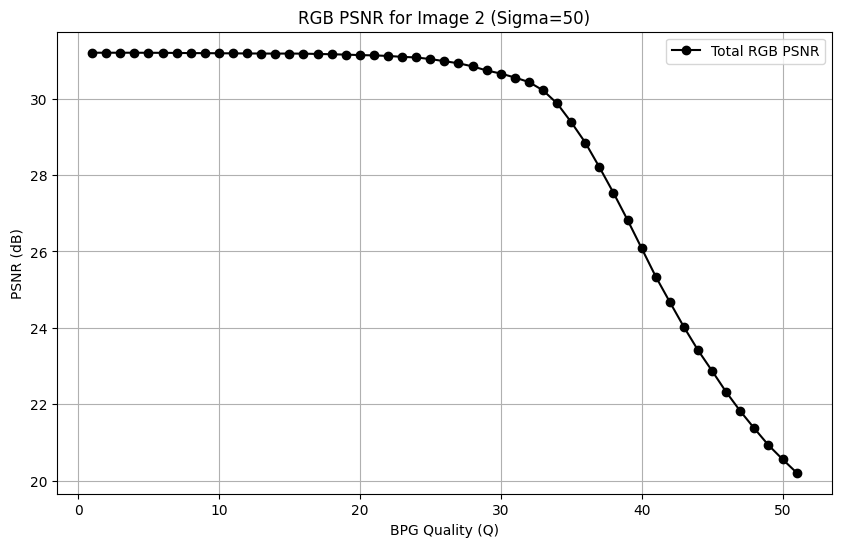


Analyzing compression for Image 2, Sigma=100
-------------------------------------------------------
Processing BPG compression with Q=1...
Ensuring output folder exists on server: /home/max/Documents/temp
Splitting channels of /home/max/Documents/noisy_sigma_100_img_2.bmp on server...
Compressing R channel to /home/max/Documents/temp/R_compressed_q1.bpg...
Decompressing R channel to /home/max/Documents/temp/R_decompressed_q1.png...
Compressing G channel to /home/max/Documents/temp/G_compressed_q1.bpg...
Decompressing G channel to /home/max/Documents/temp/G_decompressed_q1.png...
Compressing B channel to /home/max/Documents/temp/B_compressed_q1.bpg...
Decompressing B channel to /home/max/Documents/temp/B_decompressed_q1.png...
Original channel means: R=63.90, G=63.35, B=58.37
Decompressed channel means: R=63.46, G=62.95, B=57.93
PSNR per channel (Q=1): {'R': 28.265356199242365, 'G': 28.245982348109145, 'B': 28.231544413385443}
Total PSNR for RGB reconstruction (Q=1): 28.24760556525536

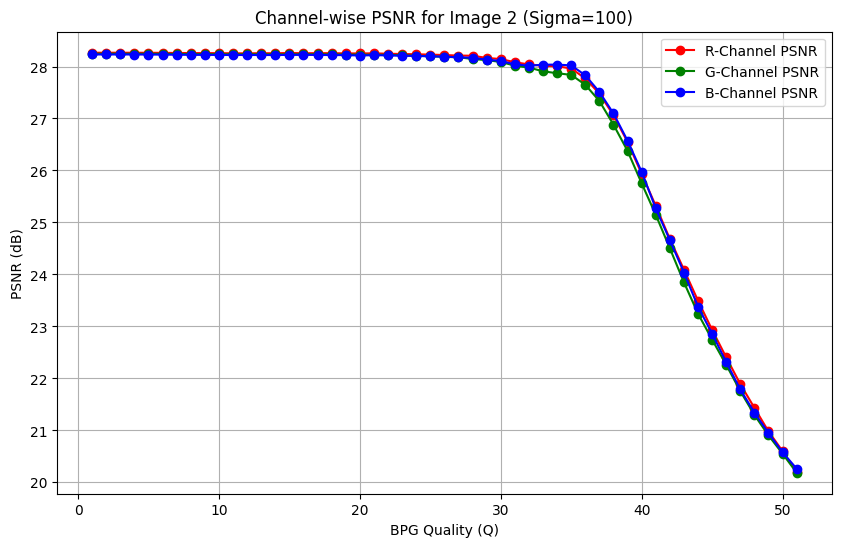

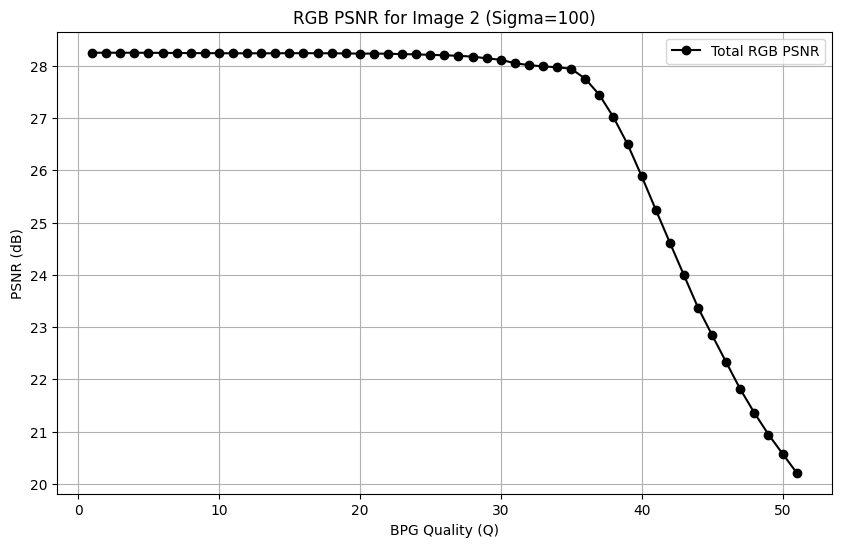

Finished processing Image 2


In [79]:
if __name__ == "__main__":

    # Paths for shared folders
    local_shared_folder = "/Users/Maksym_Rybnytskyi/Documents/UTMShare"  # Local path on MacBook
    server_shared_folder = "/home/max/Documents"  # Server path on Linux

    # Server details
    server_ip = "192.168.0.103"
    username = "max"
    password = "letmein"

    # Paths for two input images (BMP files)
    image1_path_local = os.path.join(local_shared_folder, "SS1.bmp")
    image2_path_local = os.path.join(local_shared_folder, "SS2.bmp")
    image1_path_server = os.path.join(server_shared_folder, "SS1.bmp")
    image2_path_server = os.path.join(server_shared_folder, "SS2.bmp")

    # Upload the clean BMP images to the server
    print(f"Uploading {image1_path_local} to server at {image1_path_server}...")
    upload_to_server(image1_path_local, image1_path_server, server_ip, username, password)
    print(f"Uploading {image2_path_local} to server at {image2_path_server}...")
    upload_to_server(image2_path_local, image2_path_server, server_ip, username, password)

    # Settings for independent channel processing
    sigmas = [25, 50, 100]  # Noise sigma values
    q_values = range(1, 52)  # BPG compression quality levels (Q)

    # Create temporary folder on the server for decompressed channels
    server_temp_folder = os.path.join(server_shared_folder, "temp")
    os.makedirs(local_shared_folder, exist_ok=True)  # Ensure the local folder exists

    # Process each image independently
    for idx, (image_path_local, image_path_server) in enumerate([(image1_path_local, image1_path_server), 
                                                                 (image2_path_local, image2_path_server)]):
        print(f"Processing Image {idx + 1}")
        print("-------------------------------------------------------")

        # # Load original image locally
        original_image = cv2.imread(image_path_local, cv2.IMREAD_COLOR)
        original_image_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
        results = [original_image]  # Start with the original image
        titles = ["Original"]       # Titles for display

        psnr_noise_results = []  # Store PSNR values between original and noisy images

        # # Load original image locally and convert to RGB
        # original_image_bgr = cv2.imread(image_path_local, cv2.IMREAD_COLOR)
        # original_image = cv2.cvtColor(original_image_bgr, cv2.COLOR_BGR2RGB)

        # Step 1: Add noise for various sigma values
        noisy_images = {}
        noisy_images_paths = {}
        for sigma in sigmas:
            noisy_image = add_awgn_noise(original_image, sigma)  # Add noise
            noisy_images[sigma] = noisy_image

            # Save noisy image locally and upload to the server
            noisy_image_filename = f"noisy_sigma_{sigma}_img_{idx + 1}.bmp"
            noisy_image_path_local = os.path.join(local_shared_folder, noisy_image_filename)
            noisy_image_path_server = os.path.join(server_shared_folder, noisy_image_filename)
            cv2.imwrite(noisy_image_path_local, noisy_image)
            upload_to_server(noisy_image_path_local, noisy_image_path_server, server_ip, username, password)
            noisy_images_paths[sigma] = noisy_image_path_server  # Store paths for future reference

            # Calculate PSNR between the original and noisy image (RGB + grayscale)
            psnr = calculate_psnr(original_image, noisy_image)
            psnr_noise_results.append((sigma, psnr))  # Store sigma and PSNR

            # Add the noisy image to the result list for visualization
            results.append(noisy_image)
            titles.append(f"Noise (σ^2={sigma})")

        # Display all noisy results for the current image
        display_multiple_images(results, titles)

        # Display PSNR for noisy images in the console
        print("\nPSNR values for noisy images:")
        for sigma, psnr in psnr_noise_results:
            print(f"Noise (σ={sigma}): PSNR={psnr:.2f} dB")
        print("-------------------------------------------------------")

        # Step 2: Analyze BPG Compression for each noisy version
        for sigma, noisy_image in noisy_images.items():
            
            noisy_image_path_server = noisy_images_paths[sigma]  # Ensure the correct path is loaded
            
            print(f"\nAnalyzing compression for Image {idx + 1}, Sigma={sigma}")
            print("-------------------------------------------------------")

            total_psnr_results = []  # To store PSNR for total RGB at each Q
            channel_psnr_results = {'R': [], 'G': [], 'B': []}  # To store PSNR for each channel at each Q

            for q in q_values:
                print(f"Processing BPG compression with Q={q}...")

                # Independent channel compression and decompression
                decompressed_paths = run_bpg_on_server_per_channel(
                    input_path=noisy_image_path_server,
                    output_folder=server_temp_folder,
                    quality=q,
                    server_ip=server_ip,
                    username=username,
                    password=password
                )

                # Calculate per-channel PSNR
                #debug_visualize_channels(original_image, decompressed_paths, title_prefix=f"Q={q}, Sigma={sigma} ")
                psnr_per_channel = calculate_psnr_per_channel(original_image_rgb, decompressed_paths)
                print(f"PSNR per channel (Q={q}): {psnr_per_channel}")

                # Append channel PSNR results
                channel_psnr_results['R'].append(psnr_per_channel.get('R', None))
                channel_psnr_results['G'].append(psnr_per_channel.get('G', None))
                channel_psnr_results['B'].append(psnr_per_channel.get('B', None))

                # Reconstruct the RGB image from decompressed channels
                reconstructed_rgb = reconstruct_rgb(decompressed_paths)

                # Calculate total PSNR for the RGB image
                total_psnr = calculate_total_psnr(original_image, reconstructed_rgb)
                print(f"Total PSNR for RGB reconstruction (Q={q}): {total_psnr}")
                total_psnr_results.append(total_psnr)

                # Save reconstructed RGB locally
                reconstructed_rgb_filename = f"reconstructed_q{q}_sigma_{sigma}_img_{idx + 1}.png"
                reconstructed_rgb_path_local = os.path.join(local_shared_folder, reconstructed_rgb_filename)
                cv2.imwrite(reconstructed_rgb_path_local, reconstructed_rgb)

            # Plot PSNR(Q) for each channel
            plt.figure(figsize=(10, 6))
            plt.plot(q_values, channel_psnr_results['R'], label="R-Channel PSNR", color='red', marker='o')
            plt.plot(q_values, channel_psnr_results['G'], label="G-Channel PSNR", color='green', marker='o')
            plt.plot(q_values, channel_psnr_results['B'], label="B-Channel PSNR", color='blue', marker='o')
            plt.title(f"Channel-wise PSNR for Image {idx + 1} (Sigma={sigma})")
            plt.xlabel("BPG Quality (Q)")
            plt.ylabel("PSNR (dB)")
            plt.legend()
            plt.grid(True)
            plt.show()

            # Plot total PSNR(Q) for the RGB image
            plt.figure(figsize=(10, 6))
            plt.plot(q_values, total_psnr_results, label="Total RGB PSNR", color='black', marker='o')
            plt.title(f"RGB PSNR for Image {idx + 1} (Sigma={sigma})")
            plt.xlabel("BPG Quality (Q)")
            plt.ylabel("PSNR (dB)")
            plt.legend()
            plt.grid(True)
            plt.show()

        print(f"Finished processing Image {idx + 1}")
        print("=======================================================")

# Results

We have got the following PSNR values for Noisy images without compression. This is our start point for future analysis.

### SS1 

- Noise (σ=25): PSNR=34.42 dB
- Noise (σ=50): PSNR=31.57 dB
- Noise (σ=100): PSNR=28.72 dB

### SS2

- Noise (σ=25): PSNR=34.16 dB
- Noise (σ=50): PSNR=31.21 dB
- Noise (σ=100): PSNR=28.25 dB

PSNR improvement is clearly visible for noisy image SS1(sigm2^2=100). **OOP is located around Q=35**. Also it worth nothing that PSNR metric doesn't have significant changes until Q(OOP-4). Significant grow started after Q=31.

For SS2 we have different picture. There is no visible OOP, but we can call OOP the point after which metrics start significant decrease. For SS2 this is the same as for SS1, Q=35. Also it corrspond known expression QOOP=15+10log10(σ2)

So the next investigation will be based on this results.

We will estimate classification accuracy for the following images with different noise.

- original noisy image
- noisy image with compression in OOP
- noisy image with compression in OOP-4

All images are gathered in folder ./Images/OOP+BPG

SS1.bmp  
SS2.bmp  
<!-- decompressed_q29_sigma_100_img_1.png  
decompressed_q29_sigma_100_img_2.png 
decompressed_q29_sigma_25_img_1.png  
decompressed_q29_sigma_25_img_2.png  
decompressed_q29_sigma_50_img_1.png  
decompressed_q29_sigma_50_img_2.png  
decompressed_q33_sigma_100_img_1.png  
decompressed_q33_sigma_100_img_2.png  
decompressed_q33_sigma_25_img_1.png  
decompressed_q33_sigma_25_img_2.png  
decompressed_q33_sigma_50_img_1.png  
decompressed_q33_sigma_50_img_2.png   -->

reconstructed_q31_sigma_100_img_1.png
reconstructed_q31_sigma_50_img_1.png
reconstructed_q31_sigma_25_img_1.png
reconstructed_q31_sigma_100_img_2.png
reconstructed_q31_sigma_50_img_2.png
reconstructed_q31_sigma_25_img_2.png

reconstructed_q35_sigma_100_img_1.png
reconstructed_q35_sigma_50_img_1.png
reconstructed_q35_sigma_25_img_1.png
reconstructed_q35_sigma_100_img_2.png
reconstructed_q35_sigma_50_img_2.png
reconstructed_q35_sigma_25_img_2.png

noisy_sigma_100_img_1.bmp  
noisy_sigma_100_img_2.bmp  
noisy_sigma_25_img_1.bmp  
noisy_sigma_25_img_2.bmp  
noisy_sigma_50_img_1.bmp  
noisy_sigma_50_img_2.bmp  